In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.measure import label

%matplotlib inline

In [2]:
src_dir = Path("/home/gmurugesan/projects/experimental_projects/AIMI/aimi-idc-data/tasks/lung-pet-ct/qa-results/")
df = pd.read_csv(
    str(src_dir / "qa-results.csv"),
    dtype={
        "PatientID": str,
        "StudyDate": str,
        "StudyDate_suffix": str,
        "LikertScore": str,
    },
)
val_df = df[df["Validation"]]

In [3]:
val_df = df[df["Validation"]]
val_df.head()
rad = df.loc[(df["Reviewer"]=="rad1") & (df["Validation"])]

ne = df.loc[(df["Reviewer"]=="ne1") & (df["Validation"])]

print(len(rad))
print(len(ne))

ne = df.loc[(df["Reviewer"]=="ne1")]
print(len(df["CTSeriesInstanceUID"].unique()))
print(len(ne["CTSeriesInstanceUID"].unique()))

77
77
736
736


Cohen's Kappa: 0.00
Percentage Agreement: 66.23%
[5 5 3 5 5 3 3 3 5 5 5 5 5 5 5 5 5 3 5 2 5 5 5 5 3 5 3 5 5 5 5 5 2 2 5 3 5
 5 5 2 2 5 3 2 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 3 2 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5]
[5 5 4 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 4 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 1 5 5 4 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 4 2 5 5 5 1 5 5 5 5 5
 5 5 5]


/tmp/ipykernel_3490375/3031221176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['LikertScore'] = val_df['LikertScore'].map(likert_score_mapping)


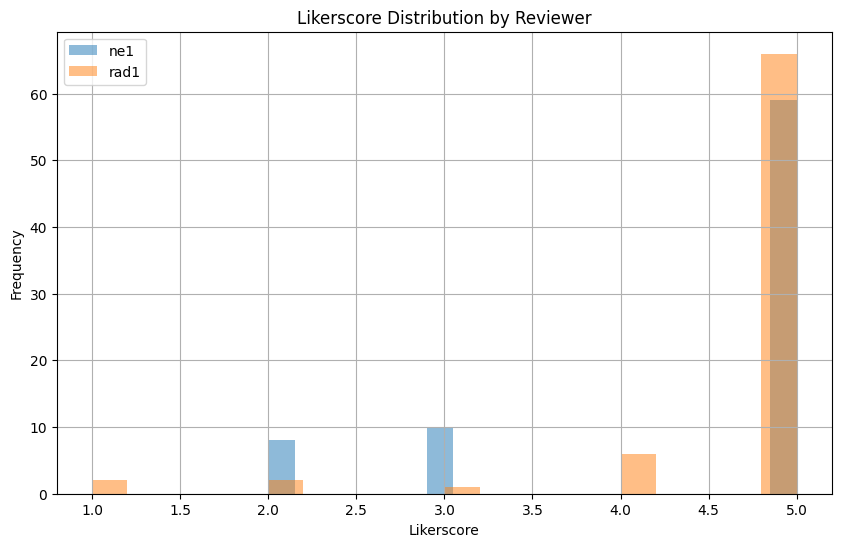

In [4]:
from sklearn.metrics import cohen_kappa_score
val_df = df[df["Validation"]]
likert_score_mapping = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
val_df['LikertScore'] = val_df['LikertScore'].map(likert_score_mapping)
rad = val_df[val_df['Reviewer']=='rad1'].LikertScore.values
ne = val_df[val_df['Reviewer']=='ne1'].LikertScore.values
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(rad, ne,labels=[1, 2, 3, 4, 5] )

print(f"Cohen's Kappa: {kappa:.2f}")
reviewers = val_df['Reviewer'].unique()

# Calculate percentage agreement
total_cases = len(rad)
matching_cases = sum(1 for r1, r2 in zip(rad, ne) if r1 == r2)
percentage_agreement = (matching_cases / total_cases) * 100

print(f"Percentage Agreement: {percentage_agreement:.2f}%")

plt.figure(figsize=(10, 6))

for reviewer in reviewers:
    subset = val_df[val_df['Reviewer'] == reviewer]
    plt.hist(subset['LikertScore'], bins=20, alpha=0.5, label=reviewer)
print(ne)
print(rad)
plt.xlabel('Likerscore')
plt.ylabel('Frequency')
plt.title('Likerscore Distribution by Reviewer')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
ne

array([5, 5, 3, 5, 5, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 2, 5, 5,
       5, 5, 3, 5, 3, 5, 5, 5, 5, 5, 2, 2, 5, 3, 5, 5, 5, 2, 2, 5, 3, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 3, 2, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [6]:
def resample(orig_img, ref_img, intep=sitk.sitkBSpline):
    f = sitk.ResampleImageFilter()
    f.SetInterpolator(intep)
    f.SetReferenceImage(ref_img)
    return f.Execute(orig_img)


def resample_label(orig_img, ref_img, intep=sitk.sitkLabelGaussian):
    f = sitk.ResampleImageFilter()
    f.SetInterpolator(intep)
    f.SetOutputPixelType(sitk.sitkUInt8)
    f.SetDefaultPixelValue(0)
    f.SetReferenceImage(ref_img)
    return f.Execute(orig_img)

def calculate_label_volume(segmentation, label_value):
    volume=0
    label_mask = sitk.Equal(segmentation, label_value)
    label_cc = sitk.ConnectedComponent(label_mask)    
    label_stats = sitk.LabelShapeStatisticsImageFilter()
    label_stats.Execute(label_cc)
    for label in label_stats.GetLabels():
        volume += label_stats.GetPhysicalSize(label)
    return volume/1000

def calculate_false_positive_and_negative_volumes(segmentation_A, segmentation_B):
    intersection = segmentation_A & segmentation_B
    false_positive = segmentation_B - intersection
    false_negative = segmentation_A - intersection
    fpv = calculate_label_volume(false_positive,1)
    fnv = calculate_label_volume(false_negative,1)
    return fpv, fnv
def calculate_f1score(ground_truth, pred):
    ground_truth = sitk.GetArrayFromImage(ground_truth)
    pred = sitk.GetArrayFromImage(pred)
    # Label connected components
    ground_truth_labels = label(ground_truth)
    predicted_labels = label(pred)
    # Identify overlapping blobs
    overlap_mask = (ground_truth_labels > 0) & (predicted_labels > 0)
    # Combine overlapping blobs
    combined_blobs = ground_truth_labels | predicted_labels
    # Remove non-overlapping blobs
    overlap_blobs = combined_blobs & overlap_mask
    tp = np.copy(ground_truth)
    tp[overlap_blobs==0]=0
    tp_lesions = len(np.unique(tp))-1
    fp = np.copy(pred)
    fp[overlap_blobs==1]=0
    fp_lesions = len(np.unique(fp))-1
    fn = np.copy(ground_truth)
    fn[overlap_blobs==1]=0
    fn_lesions = len(np.unique(fn))-1
    if tp_lesions==0:
        return 0
    else: 
        precision = tp_lesions / (tp_lesions + fp_lesions)
        recall = tp_lesions / (tp_lesions + fn_lesions)
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score
    
def calculate_detection_accuracy(ground_truth_img, pred_img):
    # Label connected components in the image and ground truth
    connected_components_image = sitk.ConnectedComponent(pred_img)
    connected_components_ground_truth = sitk.ConnectedComponent(ground_truth_img)

    # Calculate detection accuracy
    intersection = sitk.And(connected_components_image, connected_components_ground_truth)
    union = sitk.Or(connected_components_image, connected_components_ground_truth)

    intersection_area = sitk.GetArrayFromImage(intersection).sum()
    union_area = sitk.GetArrayFromImage(union).sum()

    accuracy = intersection_area / union_area
    print(f"Detection Accuracy: {accuracy:.2f}")
    return accuracy
def update_metrics(i, ai_seg,qa_seg,label_value=1, val_df = val_df):
    hd = None
    if label_value ==10: 
        ai_seg = ai_seg>0
        qa_seg = qa_seg>0
    else:
        ai_seg = sitk.BinaryThreshold(ai_seg, label_value, label_value)
        qa_seg = sitk.BinaryThreshold(qa_seg, label_value, label_value)
    stats = sitk.LabelOverlapMeasuresImageFilter()
    ai_seg = sitk.Cast(ai_seg, sitk.sitkUInt8)
    qa_seg = sitk.Cast(qa_seg, sitk.sitkUInt8)
    stats.Execute(ai_seg, qa_seg)
    val_df.loc[i, f"DICE_{label_value}"] = stats.GetDiceCoefficient()
    try:
        hausdorff = sitk.HausdorffDistanceImageFilter()
        hausdorff.Execute(ai_seg, qa_seg)    
        hd =  hausdorff.GetHausdorffDistance()
    except:
        pass
    # val_df.loc[i, "DICE"] = stats.GetDiceCoefficient()
    jaccard_distance = 1.0 - stats.GetJaccardCoefficient()
    val_df.loc[i, f"HausdorffDistance_{label_value}"] = hd

   
    # Calculate false positive and false negative volumes
    fpv, fnv = calculate_false_positive_and_negative_volumes(ai_seg, qa_seg)
    val_df.loc[i, f"FPVolume_{label_value}"] = fpv
    val_df.loc[i, f"FNVolume_{label_value}"] = fnv
    jaccard_distance = 1.0 - stats.GetJaccardCoefficient()
    val_df.loc[i, f"JaccardDistance_{label_value}"] = jaccard_distance 
    val_df.loc[i,f"f1score_{label_value}"] = calculate_detection_accuracy(qa_seg, ai_seg)


In [7]:
def calculatemetrics(reviewer, val_df):
    val_df = val_df.loc[val_df["Reviewer"]==f"{reviewer}"]
    val_df['CorrectedSegmentation'].fillna("",inplace=True)
    # val_df = val_df.loc[val_df["Reviewer"]=="rad1"]
    for i, row in val_df.iterrows():
        ai_seg_file = src_dir / "ai-segmentations" / row.AISegmentation
        if row.CorrectedSegmentation == "":
            qa_seg_file = src_dir / "ai-segmentations" / row.AISegmentation
        else: 
            qa_seg_file = src_dir / "qa-segmentations" / row.CorrectedSegmentation
        assert qa_seg_file.exists()
        assert ai_seg_file.exists()
        qa_seg = sitk.ReadImage(str(qa_seg_file))
        ai_seg = sitk.ReadImage(str(ai_seg_file))
        print(np.unique(sitk.GetArrayFromImage(ai_seg)))
        print(np.unique(sitk.GetArrayFromImage(qa_seg)))
        labels = np.unique(sitk.GetArrayFromImage(qa_seg))
        if not qa_seg.GetSize() == ai_seg.GetSize():
            ai_seg = resample_label(ai_seg, qa_seg)
        for labl in labels[1:]:
            update_metrics(i, ai_seg,qa_seg,label_value=int(labl), val_df = val_df)
    return val_df
    

In [8]:
# Create a figure with subplots
def plot_metrics(val_df, reviewer, label=1):
    rev_map={"rad1": "Expert", "ne1": "Non-expert", "ne2": "Non-expert"}
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 16))
    # Plot the first box plot in the first row, first column
    box1 = val_df.boxplot(column=[f"DICE_{label}"], ax=axes[0, 0], showmeans=True, meanline=True)
    axes[0, 0].set_title("Dice Coefficient for Lungs")
    axes[0,0].set_xticklabels([""], rotation='horizontal')

    # Plot the second box plot in the first row, second column
    val_df.boxplot(column=[f"HausdorffDistance_{label}"], ax=axes[0, 1],showmeans=True,meanline=True)
    axes[0, 1].set_title("Hausdorff Distance for Lungs")
    axes[0,1].set_xticklabels([""], rotation='horizontal')

    # Plot the third box plot in the second row, spanning both columns
    val_df.boxplot(column=[f"FPVolume_{label}", f"FNVolume_{label}"], ax=axes[1,0],showmeans=True,meanline=True)
    axes[1, 0].set_title("False Positive and False Negative Volumes for Lungs")
    axes[1,0].set_xticklabels(["FP Volume", "FN Volume"], rotation='horizontal')


    val_df.boxplot(column=[f"JaccardDistance_{label}"], ax=axes[1,1],showmeans=True,meanline=True)
    axes[1, 1].set_title("Jaccard Distance for Lungs")
    axes[1,1].set_xticklabels([""], rotation='horizontal')

    # color_palette = ['blue', 'green', 'orange', 'red', 'purple']
    # sorted_value_counts = val_df['LikertScore'].value_counts().sort_index()
    # sorted_value_counts.plot(kind='bar', ax=axes[2,0],  color=color_palette, alpha=0.5)

    label =2

    box1 = val_df.boxplot(column=[f"DICE_{label}"], ax=axes[2, 0], showmeans=True, meanline=True)
    axes[2, 0].set_title("Dice Coefficient for Lesions")
    axes[2,0].set_xticklabels([""], rotation='horizontal')

    # Plot the second box plot in the first row, second column
    val_df.boxplot(column=[f"HausdorffDistance_{label}"], ax=axes[2, 1],showmeans=True,meanline=True)
    axes[2, 1].set_title("Hausdorff Distance for Lesions")
    axes[2,1].set_xticklabels([""], rotation='horizontal')

    # Plot the third box plot in the second row, spanning both columns
    val_df.boxplot(column=[f"FPVolume_{label}", f"FNVolume_{label}"], ax=axes[3,0],showmeans=True,meanline=True)
    axes[3, 0].set_title("False Positive and False Negative Volumes for Lesions")
    axes[3,0].set_xticklabels(["FP Volume", "FN Volume"], rotation='horizontal')

    val_df.boxplot(column=[f"JaccardDistance_{label}"], ax=axes[3,1],showmeans=True,meanline=True)
    axes[3, 1].set_title("Jaccard Distance for Lesions")
    axes[3,1].set_xticklabels([""], rotation='horizontal')

    val_df.boxplot(column=[f"f1score_{label}"], ax=axes[4,0],showmeans=True,meanline=True)
    axes[4, 0].set_title("Detection Accuracy for Lesions")
    axes[4,0].set_xticklabels([""], rotation='horizontal')

    color_palette = ['blue', 'green', 'orange', 'red', 'purple']
    sorted_value_counts = val_df['LikertScore'].value_counts().sort_index()
    sorted_value_counts.plot(kind='bar', ax=axes[4,1],  color=color_palette, alpha=0.5)
    axes[4, 1].set_xlabel("Likert Scores")
    # Rotate x-axis labels to vertical orientation
    axes[4,1].set_xticklabels(sorted_value_counts.index, rotation='horizontal')
    axes[4, 1].set_title(f"{rev_map[reviewer]} Scores on AI derived annotations")
    # Adjust layout to prevent overlapping labels
    plt.tight_layout()
    fig.suptitle(f"QA Metrics between AI derived and {rev_map[reviewer]} Annotations on IDC Lung PET-CT Collections (N= {len(val_df)})",  fontsize=16, y=1.02)
    plt.show()

def get_mean(val_df):
    likert_score_mapping = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
    val_df['LikertScore'] = val_df['LikertScore'].map(likert_score_mapping)
    for label in range(1,3):
        print(f"{val_df[f'DICE_{label}'].mean()}+/-{val_df[f'DICE_{label}'].std()}")
        print(f"{val_df[f'HausdorffDistance_{label}'].mean()}+/-{val_df[f'HausdorffDistance_{label}'].std()}")
        print(f"{val_df[f'FPVolume_{label}'].mean()}+/-{val_df[f'FPVolume_{label}'].std()}")
        print(f"{val_df[f'FNVolume_{label}'].mean()}+/-{val_df[f'FNVolume_{label}'].std()}")
        print(f"{val_df[f'JaccardDistance_{label}'].mean()}+/-{val_df[f'JaccardDistance_{label}'].std()}")
        print(f"{val_df[f'f1score_{label}'].mean()}+/-{val_df[f'f1score_{label}'].std()}")
        print('*'*100)
    print(f"{val_df['LikertScore'].mean()}+/-{val_df['LikertScore'].std()}")



/tmp/ipykernel_3490375/1477921656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['CorrectedSegmentation'].fillna("",inplace=True)


[0. 1. 2.]
[0. 1. 2.]


/tmp/ipykernel_3490375/3614788522.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"DICE_{label_value}"] = stats.GetDiceCoefficient()
/tmp/ipykernel_3490375/3614788522.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"HausdorffDistance_{label_value}"] = hd
/tmp/ipykernel_3490375/3614788522.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Detection Accuracy: 1.00
Detection Accuracy: 1.00


/tmp/ipykernel_3490375/3614788522.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"HausdorffDistance_{label_value}"] = hd
/tmp/ipykernel_3490375/3614788522.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"FPVolume_{label_value}"] = fpv
/tmp/ipykernel_3490375/3614788522.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 1.00
Detection Accuracy: 0.22
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1.]
[0. 1.]
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 1.00
Detection Accuracy: 0.77
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 1.00
Detection Accuracy: 0.95
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection 

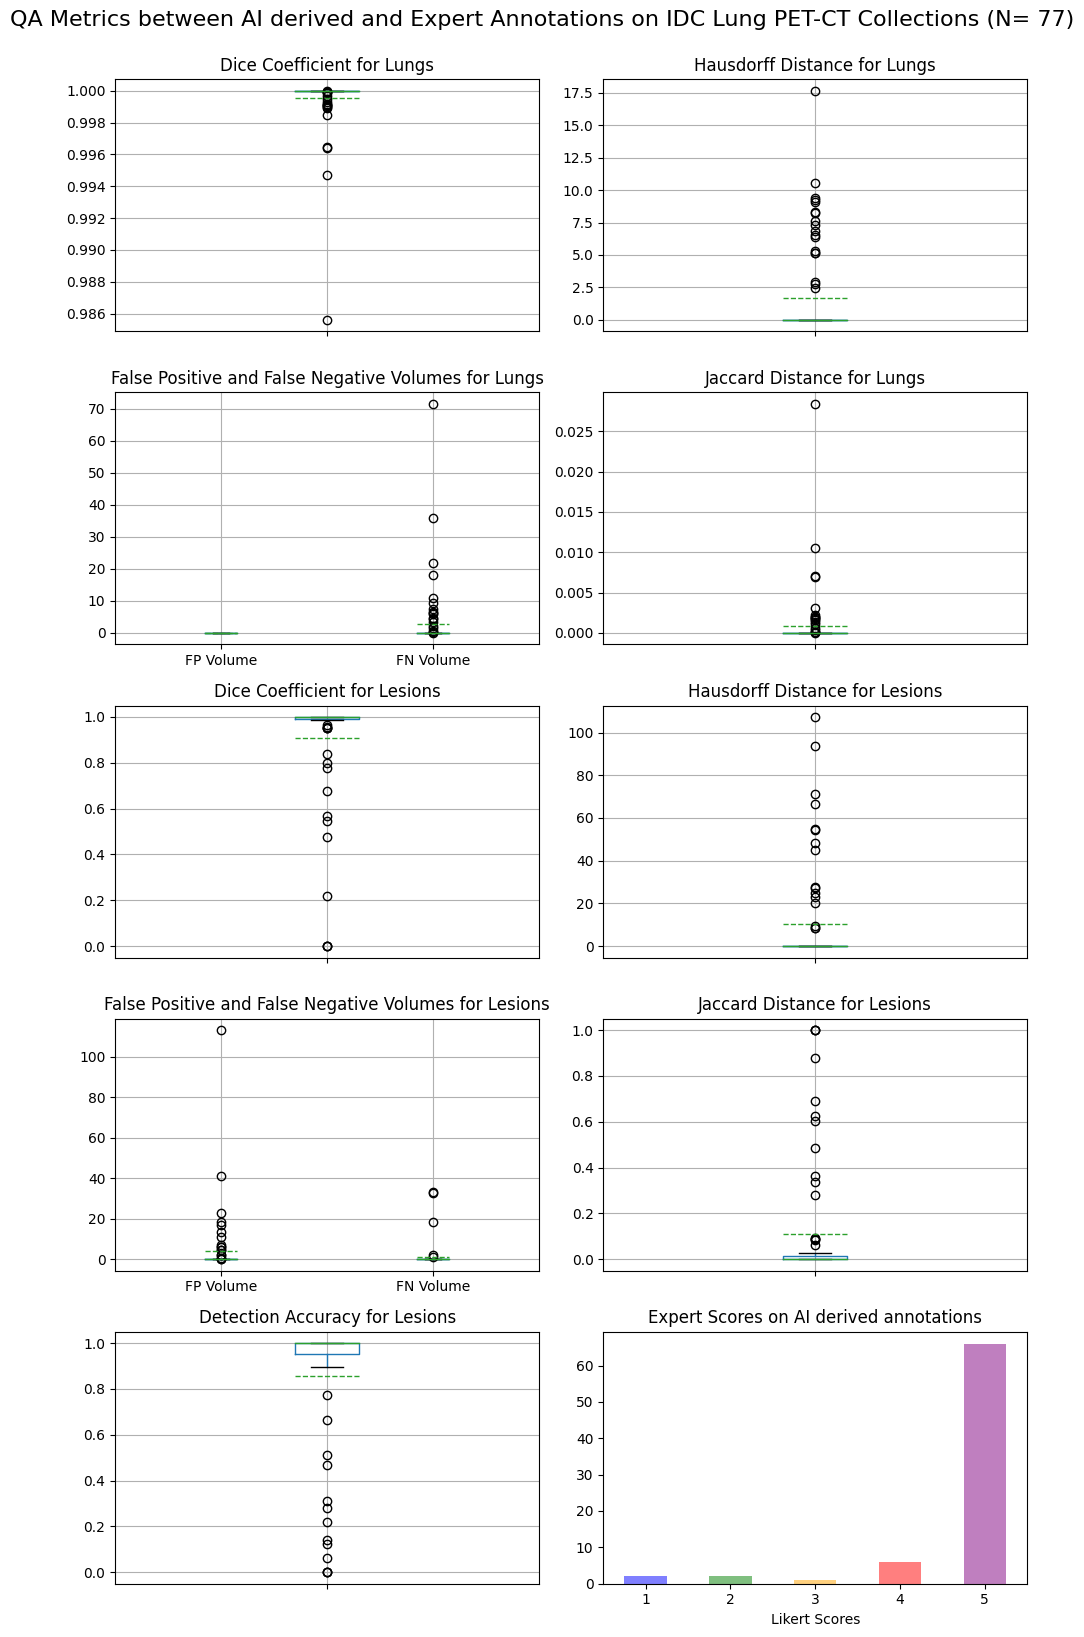

0.9995346256467464+/-0.001821270425782337
1.7005211983269288+/-3.5144498124737718
0.0+/-0.0
2.741554615177281+/-9.637343976398817
0.0009238503900653338+/-0.0035983418761537105
0.9989230094934564+/-0.004718142196439741
****************************************************************************************************
0.9080434592544939+/-0.24027896491281947
10.451142450144964+/-23.582842498781325
3.920442030324811+/-14.893287435307164
1.2623435360107238+/-5.922349080148585
0.11201143409423304+/-0.2637174830841423
0.8571261524292585+/-0.304433372985843
****************************************************************************************************
nan+/-nan


/tmp/ipykernel_3490375/721987682.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['LikertScore'] = val_df['LikertScore'].map(likert_score_mapping)


In [9]:
rad_df = calculatemetrics('rad1', val_df)
plot_metrics(rad_df, 'rad1', 1)
get_mean(rad_df)

/tmp/ipykernel_3490375/1477921656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['CorrectedSegmentation'].fillna("",inplace=True)


[0. 1. 2.]
[0. 1. 2.]


/tmp/ipykernel_3490375/3614788522.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"DICE_{label_value}"] = stats.GetDiceCoefficient()
/tmp/ipykernel_3490375/3614788522.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"HausdorffDistance_{label_value}"] = hd
/tmp/ipykernel_3490375/3614788522.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Detection Accuracy: 1.00
Detection Accuracy: 1.00


/tmp/ipykernel_3490375/3614788522.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"HausdorffDistance_{label_value}"] = hd
/tmp/ipykernel_3490375/3614788522.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[i, f"FPVolume_{label_value}"] = fpv
/tmp/ipykernel_3490375/3614788522.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 1.00
Detection Accuracy: 0.19
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1.]
[0. 1.]
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 1.00
Detection Accuracy: 0.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 0.72
Detection Accuracy: 1.00
[0. 1. 2.]
[0 1 2]
Detection Accuracy: 0.10
Detection Accuracy: 0.85
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Accuracy: 1.00
Detection Accuracy: 1.00
[0. 1. 2.]
[0. 1. 2.]
Detection Acc

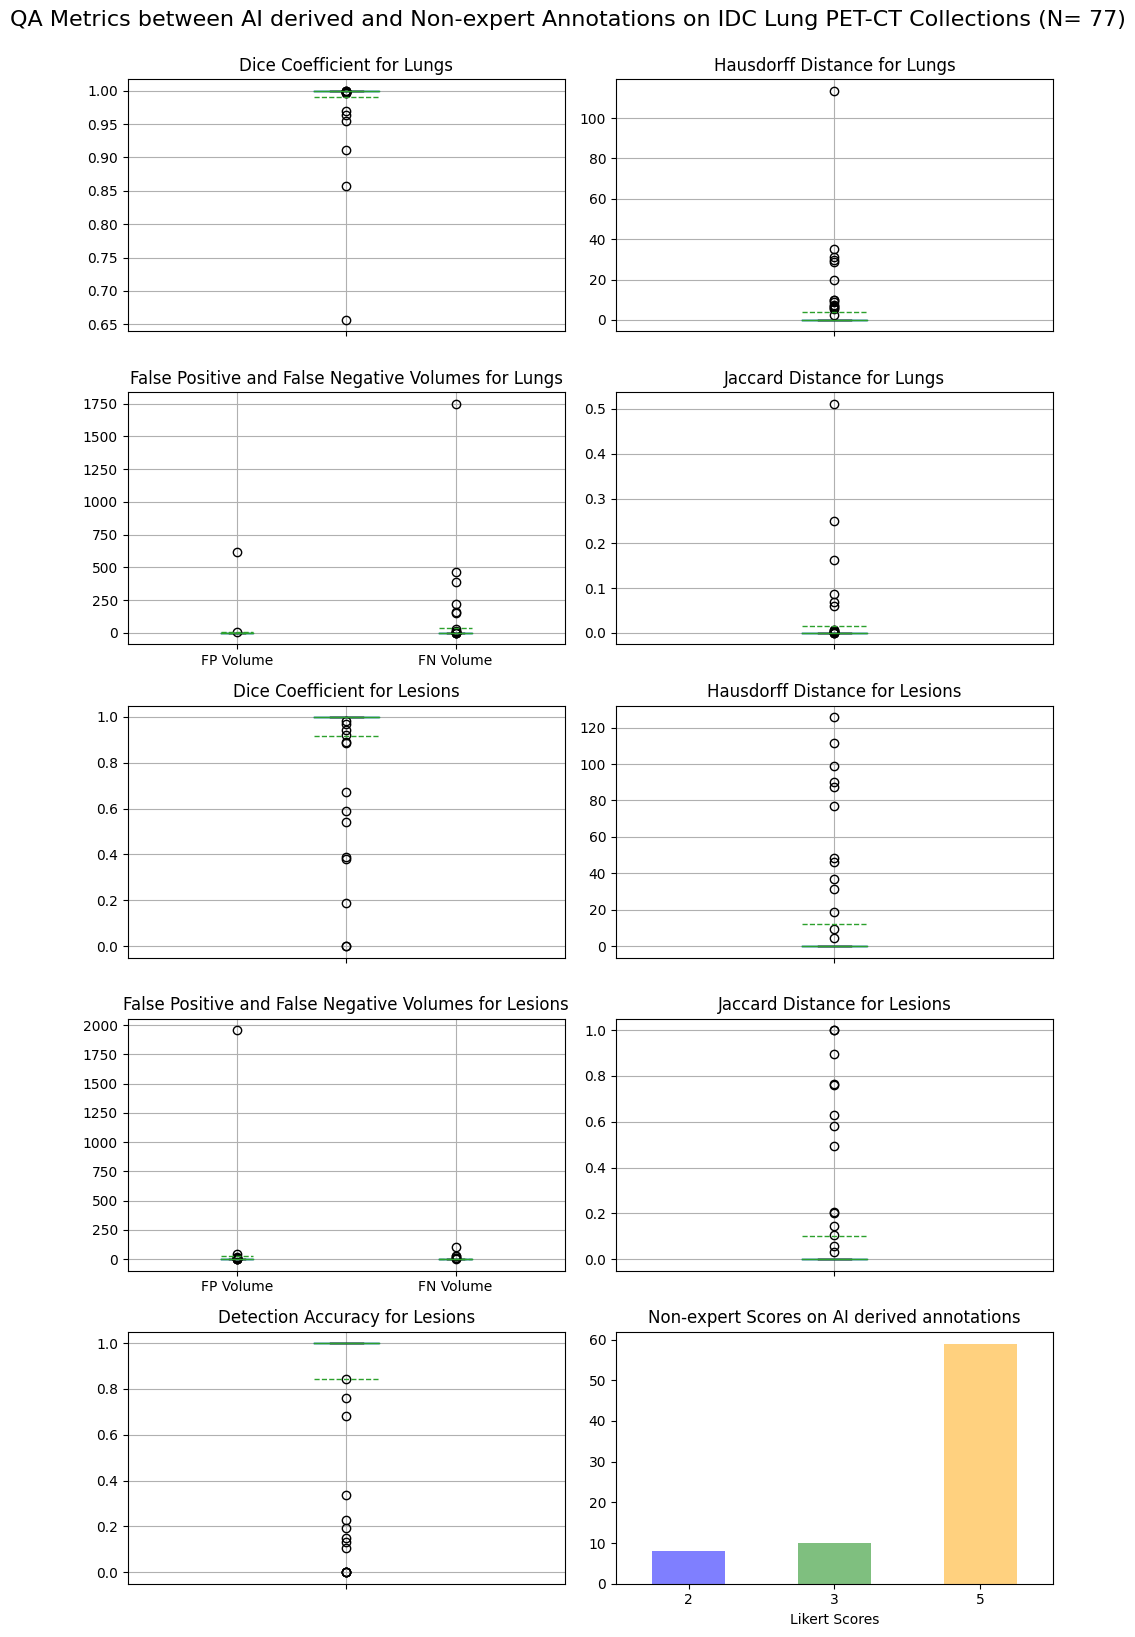

0.9909049316372905+/-0.043567438356870325
4.163092126985741+/-14.658393738149307
8.152294326759984+/-70.82443669832772
41.78023622744743+/-211.24432991951696
0.015148773577995213+/-0.0677591730601974
0.9680199473371651+/-0.14007909527021328
****************************************************************************************************
0.915705643930249+/-0.2291064742378104
11.91892471556585+/-29.78815899025146
30.66334063488737+/-239.08442664360993
2.703890682713097+/-13.121582340249596
0.10258586733422513+/-0.25699386969026233
0.8422308145273029+/-0.33674676628731043
****************************************************************************************************
nan+/-nan


/tmp/ipykernel_3490375/721987682.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['LikertScore'] = val_df['LikertScore'].map(likert_score_mapping)


In [10]:
from skimage.measure import label

ne_df = calculatemetrics('ne1', val_df)
plot_metrics(ne_df, 'ne1', 1)
get_mean(ne_df)

In [11]:
metrics_df = pd.concat([rad_df,ne_df],ignore_index=True)
metrics_df.to_csv(str(src_dir / "qa-dice.csv"), index=False)

In [12]:
# val_df.to_csv("/home/gmurugesan/projects/experimental_projects/AIMI/aimi-idc-data/tasks/lung-pet-ct/qa-results/qa-dice.csv", index=False)


# Finding missing case

In [13]:
# ACRIN Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/acrin_nsclc_fdg_pet/nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# ACRIN QA
acring_qa = df.loc[(df["Collection"]=="acrin_nsclc_fdg_pet")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 369")
print(f"Images Infered: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

371
367
Images Infered: 369
Images Infered: 367


In [14]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/anti_pd_1_lung/sitk_nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="anti_pd_1_lung")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 43")
print(f"Images Infered: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

44
43
Images Infered: 43
Images Infered: 43


In [15]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/lung_pet_ct_dx/sitk_nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="lung_pet_ct_dx")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 46")
print(f"Images Infered: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

48
46
Images Infered: 46
Images Infered: 46


In [16]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/nsclc_radiogenomics/sitk_nii/inference_summary_ensemble_CT.csv")
acrin_inference_summary_fusion = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/nsclc_radiogenomics/sitk_nii/inference_summary_ensemble_fusion.csv")
concatenated_df = pd.concat([acrin_inference_summary, acrin_inference_summary_fusion], ignore_index=True)
print(len(acrin_inference_summary))
print(len(acrin_inference_summary_fusion))
print(len(concatenated_df))
ct_list = concatenated_df["CT"].values
suid=[]
# for ct in ct_list:
# #     # + acrin_inference_summary_fusion["CT"].values
# print(len(ct))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="nsclc_radiogenomics")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 195")
print(f"Images in qa: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

136
59
195
194
Images Infered: 195
Images in qa: 194


In [17]:
val_df.columns

Index(['Reviewer', 'Validation', 'Collection', 'PatientID', 'StudyDate',
       'LikertScore', 'CorrectedSegmentation', 'CommentsAboutAISegmentation',
       'CommentsAboutScan', 'StudyInstanceUID', 'PTSeriesInstanceUID',
       'CTSeriesInstanceUID', 'StudyDate_suffix', 'AISegmentation'],
      dtype='object')

In [18]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/tcga_lihc/nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))

# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="tcga_lihc")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 1")
print(f"Images in qa: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

1
0
Images Infered: 1
Images in qa: 0


In [19]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/rider_lung_pet_ct/sitk_nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="rider_lung_pet_ct")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 55")
print(f"Images in qa: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

58
55
Images Infered: 55
Images in qa: 55


In [20]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/tcga_luad/sitk_nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="tcga_luad")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 20")
print(f"Images in qa: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

20
20
Images Infered: 20
Images in qa: 20


In [21]:
# anti_pd_1_lung Inference summary
acrin_inference_summary = pd.read_csv("/mnt/nfs/slow_ai_team/aimi/tcga_lusc/sitk_nii/inference_summary_ensemble_CT.csv")
print(len(acrin_inference_summary))
# anti_pd_1_lung QA
acring_qa = df.loc[(df["Collection"]=="tcga_lusc")]
print(len(acring_qa["CTSeriesInstanceUID"].unique()))

print("Images Infered: 11")
print(f"Images in qa: {len(acring_qa['CTSeriesInstanceUID'].unique())}")

0
11
Images Infered: 11
Images in qa: 11


In [22]:
print(len(df["CTSeriesInstanceUID"].unique()))

736
